In [1]:
import os
import sys
import pandas as pd
import yaml 
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
import statsmodels.api as sm
import numpy as np
from itertools import product
import subprocess

with open("../../config.yaml.local", "r") as f:
    LOCAL_CONFIG = yaml.safe_load(f)
#with open("../../config.yaml", "r") as f:
#    CONFIG = yaml.safe_load(f)
sys.path.append("../python")

import globals
import data_tools as dt

LOCAL_PATH = LOCAL_CONFIG["LOCAL_PATH"]
RAW_DATA_PATH = LOCAL_CONFIG["RAW_DATA_PATH"]
DATA_PATH = LOCAL_CONFIG["DATA_PATH"]
R_PATH = LOCAL_CONFIG["R_PATH"]

RUN_R_SCRIPTS = False


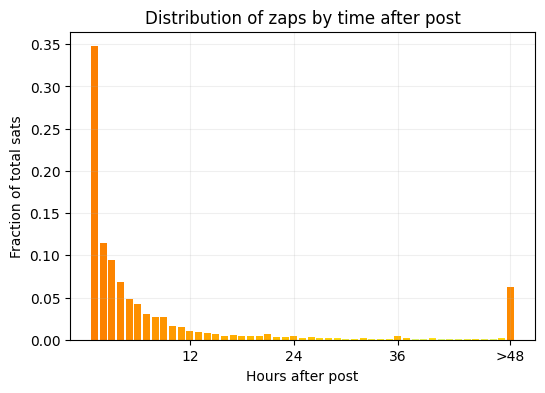

In [3]:
# ---- Show distribution of zaps in first 48 hours

zaps = dt.get_zaps()
posts = dt.get_posts()

# select posts to consider
mask = (posts['invoiceActionState'] != 'FAILED') & \
       (~posts['bio']) & (~posts['freebie']) & (~posts['saloon']) & \
       (posts['subName'].notnull()) & (posts['subName'] != '') & \
       (~posts['subName'].isin(['jobs', 'ama']))
posts = posts.loc[mask].reset_index(drop=True)

# get post creation times
right = posts[['itemId', 'created_at']].rename(
    columns = {'created_at': 'post_created_at'}
).reset_index(drop=True)

# append post creation times to zaps
zaps = zaps.merge(right, on='itemId', how='inner')

# hours after post for zaps
zaps['hours_after_post'] = np.ceil((zaps['zap_time'] - zaps['post_created_at']).dt.total_seconds() / 3600)
zaps['hours_after_post'] = zaps['hours_after_post'].clip(upper=49)

# plot distribution by hour
hours = zaps.groupby(['hours_after_post']).agg(
    sats = ('sats', 'sum')
).reset_index()
hours['frac'] = hours['sats'] / hours['sats'].sum()
hours = hours.sort_values(by='frac', ascending=True).reset_index(drop=True)
colors = plt.cm.Wistia(np.linspace(0.0,1,len(hours)))
plt.figure(figsize=(6,4))
plt.bar(hours['hours_after_post'], hours['frac'], color=colors)
plt.xticks(ticks=[12, 24, 36, 49], labels=['12', '24', '36', '>48'])
plt.xlabel('Hours after post')
plt.ylabel('Fraction of total sats')
plt.grid(alpha=0.2)
plt.title('Distribution of zaps by time after post')
plt.show()


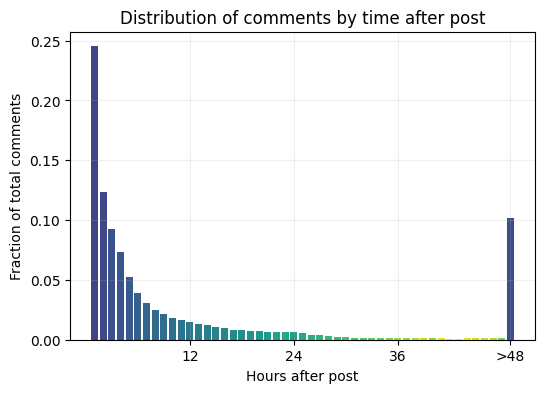

In [5]:
# ---- Show distribution of comments in first 48 hours

comments = dt.get_comments()
posts = dt.get_posts()

# select posts to consider
mask = (posts['invoiceActionState'] != 'FAILED') & \
       (~posts['bio']) & (~posts['freebie']) & (~posts['saloon']) & \
       (posts['subName'].notnull()) & (posts['subName'] != '') & \
       (~posts['subName'].isin(['jobs', 'ama']))
posts = posts.loc[mask].reset_index(drop=True)

# select comments to consider
mask = (comments['invoiceActionState'] != 'FAILED')
comments = comments.loc[mask].reset_index(drop=True)

# get post creation times
right = posts[['itemId', 'created_at']].rename(
    columns = {'itemId': 'rootId', 'created_at': 'post_created_at'}
).reset_index(drop=True)

# append post creation times to zaps
comments = comments.merge(right, on='rootId', how='inner')

# hours after post for zaps
comments['hours_after_post'] = np.ceil((comments['created_at'] - comments['post_created_at']).dt.total_seconds() / 3600)
comments['hours_after_post'] = comments['hours_after_post'].clip(upper=49)

# plot distribution by hour
hours = comments.groupby(['hours_after_post']).agg(
    n_comments = ('itemId', 'count')
).reset_index()
hours['frac'] = hours['n_comments'] / hours['n_comments'].sum()
hours = hours.sort_values(by='frac', ascending=True).reset_index(drop=True)
colors = plt.cm.viridis_r(np.linspace(0.0,0.8,len(hours)))
plt.figure(figsize=(6,4))
plt.bar(hours['hours_after_post'], hours['frac'], color=colors)
plt.xticks(ticks=[12, 24, 36, 49], labels=['12', '24', '36', '>48'])
plt.xlabel('Hours after post')
plt.ylabel('Fraction of total comments')
plt.grid(alpha=0.2)
plt.title('Distribution of comments by time after post')
plt.show()